In [1]:
# CELL 1: Import Libraries
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("="*70)
print("MONTHLY TB PREDICTION - MODEL DEVELOPMENT")
print("="*70)
print("\n✓ Libraries imported successfully!")


MONTHLY TB PREDICTION - MODEL DEVELOPMENT

✓ Libraries imported successfully!


In [6]:
# CELL 2: Load Monthly Processed Data
# ------------------------------------------------------------
print("\n" + "="*70)
print("LOADING MONTHLY DATA")
print("="*70)

# Load monthly processed data
df = pd.read_csv('data/monthly/tb_monthly_processed.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

print(f"✓ Monthly data loaded successfully!")
print(f"\nDataset Information:")
print(f"  Shape: {df.shape}")
print(f"  Rows: {df.shape[0]:,} (monthly observations)")
print(f"  Columns: {df.shape[1]}")

print(f"\nColumns ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nDate Range:")
print(f"  Start: {df['date'].min()}")
print(f"  End: {df['date'].max()}")
print(f"  Months: {len(df['date'].unique())}")

print(f"\nDistricts: {df['district'].nunique()}")
print(f"  {sorted(df['district'].unique())}")

print(f"\nTB Case Statistics:")
print(f"  Total: {df['tb_case'].sum():,}")
print(f"  Mean/month: {df['tb_case'].mean():.2f}")
print(f"  Median/month: {df['tb_case'].median():.2f}")
print(f"  Min: {df['tb_case'].min()}")
print(f"  Max: {df['tb_case'].max()}")



LOADING MONTHLY DATA
✓ Monthly data loaded successfully!

Dataset Information:
  Shape: (3696, 14)
  Rows: 3,696 (monthly observations)
  Columns: 14

Columns (14):
   1. district
   2. date
   3. tb_case
   4. co
   5. nh3
   6. no2
   7. o3
   8. pm10
   9. so2
  10. humidity
  11. avg_temp
  12. air_pressure
  13. solar_radiation
  14. precipitation

Date Range:
  Start: 2021-01-01 00:00:00
  End: 2024-12-01 00:00:00
  Months: 48

Districts: 77
  ['Achham', 'Arghakhanchi', 'Baglung', 'Baitadi', 'Bajhang', 'Bajura', 'Banke', 'Bara', 'Bardiya', 'Bhaktapur', 'Bhojpur', 'Chitwan', 'Dadeldhura', 'Dailekh', 'Dang', 'Darchula', 'Dhading', 'Dhankuta', 'Dhanusa', 'Dolakha', 'Dolpa', 'Doti', 'Gorkha', 'Gulmi', 'Humla', 'Ilam', 'Jajarkot', 'Jhapa', 'Jumla', 'Kailali', 'Kalikot', 'Kanchanpur', 'Kapilvastu', 'Kaski', 'Kathmandu', 'Kavrepalanchok', 'Khotang', 'Lalitpur', 'Lamjung', 'Mahottari', 'Makwanpur', 'Manang', 'Morang', 'Mugu', 'Mustang', 'Myagdi', 'Nawalparasi East', 'Nawalparasi West', 

In [7]:
# CELL 3: Prepare Features and Target
# ------------------------------------------------------------
print("\n" + "="*70)
print("PREPARING FEATURES AND TARGET")
print("="*70)

# Columns to drop (non-predictive)
drop_cols = ['date']

# Handle district - check if it should be encoded or dropped
# For now, we'll drop it (can add one-hot encoding later if needed)
drop_cols.append('district')

# Target variable
target = 'tb_case'

# Feature columns
feature_cols = [col for col in df.columns if col not in drop_cols + [target]]

print(f"-> Preparing features and target...")
print(f"\nColumns to drop: {drop_cols}")
print(f"Target variable: {target}")
print(f"Feature columns: {len(feature_cols)}")

# Separate features and target
X = df[feature_cols].copy()
y = df[target].copy()

print(f"\n✓ Features and target prepared!")
print(f"\nFeature matrix (X):")
print(f"  Shape: {X.shape}")
print(f"  Features: {len(feature_cols)}")

print(f"\nTarget variable (y):")
print(f"  Shape: {y.shape}")
print(f"  Mean: {y.mean():.2f}")
print(f"  Std: {y.std():.2f}")

print(f"\nFeatures:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Check for any remaining missing values
print(f"\nMissing values check:")
print(f"  X: {X.isnull().sum().sum()}")
print(f"  y: {y.isnull().sum()}")



PREPARING FEATURES AND TARGET
-> Preparing features and target...

Columns to drop: ['date', 'district']
Target variable: tb_case
Feature columns: 11

✓ Features and target prepared!

Feature matrix (X):
  Shape: (3696, 11)
  Features: 11

Target variable (y):
  Shape: (3696,)
  Mean: 37.09
  Std: 45.76

Features:
   1. co
   2. nh3
   3. no2
   4. o3
   5. pm10
   6. so2
   7. humidity
   8. avg_temp
   9. air_pressure
  10. solar_radiation
  11. precipitation

Missing values check:
  X: 0
  y: 0


In [8]:
# CELL 4: Temporal Train-Test Split
# ------------------------------------------------------------
print("\n" + "="*70)
print("TEMPORAL TRAIN-TEST SPLIT")
print("="*70)

# Sort by date to ensure proper temporal ordering
df_sorted = df.sort_values('date').reset_index(drop=True)

# Get sorted features and target
X_sorted = df_sorted[feature_cols].copy()
y_sorted = df_sorted[target].copy()
dates_sorted = df_sorted['date']

# 80-20 temporal split
split_index = int(len(df_sorted) * 0.8)

# Split features and target
X_train = X_sorted.iloc[:split_index].copy()
X_test = X_sorted.iloc[split_index:].copy()
y_train = y_sorted.iloc[:split_index].copy()
y_test = y_sorted.iloc[split_index:].copy()

# Split dates for reference
train_dates = dates_sorted.iloc[:split_index]
test_dates = dates_sorted.iloc[split_index:]

print(f"✓ Temporal split complete!")
print(f"\nTraining Set:")
print(f"  Samples: {X_train.shape[0]:,} ({X_train.shape[0]/len(df_sorted)*100:.1f}%)")
print(f"  Date range: {train_dates.min()} to {train_dates.max()}")
print(f"  TB cases - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")

print(f"\nTesting Set:")
print(f"  Samples: {X_test.shape[0]:,} ({X_test.shape[0]/len(df_sorted)*100:.1f}%)")
print(f"  Date range: {test_dates.min()} to {test_dates.max()}")
print(f"  TB cases - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

print(f"\nFeature dimensions:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")



TEMPORAL TRAIN-TEST SPLIT
✓ Temporal split complete!

Training Set:
  Samples: 2,956 (80.0%)
  Date range: 2021-01-01 00:00:00 to 2024-03-01 00:00:00
  TB cases - Mean: 35.41, Std: 44.15

Testing Set:
  Samples: 740 (20.0%)
  Date range: 2024-03-01 00:00:00 to 2024-12-01 00:00:00
  TB cases - Mean: 43.81, Std: 51.21

Feature dimensions:
  X_train: (2956, 11)
  X_test: (740, 11)
  y_train: (2956,)
  y_test: (740,)


In [9]:
# CELL 5: Feature Scaling for SVR and BPNN
# ------------------------------------------------------------
print("\n" + "="*70)
print("FEATURE SCALING")
print("="*70)

print("-> Scaling features for SVR and BPNN...")
print("   (Random Forest doesn't require scaling)")

# Initialize scaler
scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Scaling complete!")
print(f"  Scaler fitted on training data")
print(f"  Applied to both train and test sets")

# Show scaling parameters for first few features
print(f"\nScaling parameters (first 5 features):")
print(f"{'Feature':<20} {'Mean':<12} {'Std':<12}")
print("-" * 44)
for i, feature in enumerate(feature_cols[:5]):
    print(f"{feature:<20} {scaler.mean_[i]:>11.4f} {scaler.scale_[i]:>11.4f}")



FEATURE SCALING
-> Scaling features for SVR and BPNN...
   (Random Forest doesn't require scaling)

✓ Scaling complete!
  Scaler fitted on training data
  Applied to both train and test sets

Scaling parameters (first 5 features):
Feature              Mean         Std         
--------------------------------------------
co                      676.9053    551.5551
nh3                       7.8353      9.6809
no2                       5.9448      8.3780
o3                       56.0124     18.1824
pm10                     70.0268     76.1052


In [13]:
# CELL 6: MODEL 1 - Random Forest Regressor
# ------------------------------------------------------------
print("\n" + "="*70)
print("MODEL 1: RANDOM FOREST REGRESSOR")
print("="*70)

print("-> Initializing Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=200,       # number of trees
    max_depth=10,           # maximum tree depth
    min_samples_split=5,    # minimum samples to split
    min_samples_leaf=2,     # minimum samples in leaf
    random_state=42,
    n_jobs=-1               # use all CPU cores
)

print(f"   Hyperparameters:")
print(f"     n_estimators: 100")
print(f"     max_depth: 10")
print(f"     min_samples_split: 5")
print(f"     min_samples_leaf: 2")

print(f"\n-> Training Random Forest...")
rf_model.fit(X_train, y_train)
print(f"   ✓ Training complete!")

# Predictions
print(f"\n-> Making predictions...")
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

# Evaluate
mae_train_rf = mean_absolute_error(y_train, y_pred_rf_train)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
r2_train_rf = r2_score(y_train, y_pred_rf_train)

mae_test_rf = mean_absolute_error(y_test, y_pred_rf_test)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
r2_test_rf = r2_score(y_test, y_pred_rf_test)

print(f"\n" + "-"*70)
print("RANDOM FOREST RESULTS")
print("-"*70)
print(f"\nTraining Set:")
print(f"  MAE:  {mae_train_rf:.4f}")
print(f"  RMSE: {rmse_train_rf:.4f}")
print(f"  R²:   {r2_train_rf:.4f}")

print(f"\nTesting Set:")
print(f"  MAE:  {mae_test_rf:.4f}")
print(f"  RMSE: {rmse_test_rf:.4f}")
print(f"  R²:   {r2_test_rf:.4f}")

# Overfitting check
print(f"\nOverfitting Check:")
print(f"  R² difference: {r2_train_rf - r2_test_rf:.4f}")
if r2_train_rf - r2_test_rf < 0.1:
    print(f"  ✓ Good generalization")
elif r2_train_rf - r2_test_rf < 0.2:
    print(f"  ⚠ Slight overfitting")
else:
    print(f"  ❌ Significant overfitting")



MODEL 1: RANDOM FOREST REGRESSOR
-> Initializing Random Forest model...
   Hyperparameters:
     n_estimators: 100
     max_depth: 10
     min_samples_split: 5
     min_samples_leaf: 2

-> Training Random Forest...
   ✓ Training complete!

-> Making predictions...

----------------------------------------------------------------------
RANDOM FOREST RESULTS
----------------------------------------------------------------------

Training Set:
  MAE:  7.7611
  RMSE: 12.3542
  R²:   0.9217

Testing Set:
  MAE:  16.1269
  RMSE: 30.9596
  R²:   0.6340

Overfitting Check:
  R² difference: 0.2877
  ❌ Significant overfitting


In [14]:
# CELL 7: MODEL 2 - Support Vector Regressor (SVR)
# ------------------------------------------------------------
print("\n" + "="*70)
print("MODEL 2: SUPPORT VECTOR REGRESSOR (SVR)")
print("="*70)

print("-> Initializing SVR model...")
svr_model = SVR(
    kernel='rbf',           # radial basis function kernel
    C=10,                   # regularization parameter
    gamma='scale',          # kernel coefficient
    epsilon=0.1             # epsilon in epsilon-SVR
)

print(f"   Hyperparameters:")
print(f"     kernel: rbf")
print(f"     C: 10")
print(f"     gamma: scale")
print(f"     epsilon: 0.1")

print(f"\n-> Training SVR (this may take a moment)...")
svr_model.fit(X_train_scaled, y_train)
print(f"   ✓ Training complete!")

# Predictions
print(f"\n-> Making predictions...")
y_pred_svr_train = svr_model.predict(X_train_scaled)
y_pred_svr_test = svr_model.predict(X_test_scaled)

# Evaluate
mae_train_svr = mean_absolute_error(y_train, y_pred_svr_train)
rmse_train_svr = np.sqrt(mean_squared_error(y_train, y_pred_svr_train))
r2_train_svr = r2_score(y_train, y_pred_svr_train)

mae_test_svr = mean_absolute_error(y_test, y_pred_svr_test)
rmse_test_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr_test))
r2_test_svr = r2_score(y_test, y_pred_svr_test)

print(f"\n" + "-"*70)
print("SVR RESULTS")
print("-"*70)
print(f"\nTraining Set:")
print(f"  MAE:  {mae_train_svr:.4f}")
print(f"  RMSE: {rmse_train_svr:.4f}")
print(f"  R²:   {r2_train_svr:.4f}")

print(f"\nTesting Set:")
print(f"  MAE:  {mae_test_svr:.4f}")
print(f"  RMSE: {rmse_test_svr:.4f}")
print(f"  R²:   {r2_test_svr:.4f}")

# Overfitting check
print(f"\nOverfitting Check:")
print(f"  R² difference: {r2_train_svr - r2_test_svr:.4f}")
if r2_train_svr - r2_test_svr < 0.1:
    print(f"  ✓ Good generalization")
elif r2_train_svr - r2_test_svr < 0.2:
    print(f"  ⚠ Slight overfitting")
else:
    print(f"  ❌ Significant overfitting")



MODEL 2: SUPPORT VECTOR REGRESSOR (SVR)
-> Initializing SVR model...
   Hyperparameters:
     kernel: rbf
     C: 10
     gamma: scale
     epsilon: 0.1

-> Training SVR (this may take a moment)...
   ✓ Training complete!

-> Making predictions...

----------------------------------------------------------------------
SVR RESULTS
----------------------------------------------------------------------

Training Set:
  MAE:  15.2636
  RMSE: 29.6613
  R²:   0.5484

Testing Set:
  MAE:  20.9927
  RMSE: 38.5822
  R²:   0.4315

Overfitting Check:
  R² difference: 0.1169
  ⚠ Slight overfitting


In [15]:
# CELL 8: MODEL 3 - BP Neural Network (BPNN)
# ------------------------------------------------------------
print("\n" + "="*70)
print("MODEL 3: BP NEURAL NETWORK (BPNN)")
print("="*70)

print("-> Initializing BPNN model...")
bpnn_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # two hidden layers
    activation='relu',              # activation function
    solver='adam',                  # optimizer
    max_iter=500,                   # maximum iterations
    random_state=42,
    early_stopping=True,            # enable early stopping
    validation_fraction=0.1         # 10% for validation
)

print(f"   Hyperparameters:")
print(f"     hidden_layers: (100, 50)")
print(f"     activation: relu")
print(f"     solver: adam")
print(f"     max_iter: 500")
print(f"     early_stopping: True")

print(f"\n-> Training BPNN...")
bpnn_model.fit(X_train_scaled, y_train)
print(f"   ✓ Training complete!")
print(f"   Iterations: {bpnn_model.n_iter_}")

# Predictions
print(f"\n-> Making predictions...")
y_pred_bpnn_train = bpnn_model.predict(X_train_scaled)
y_pred_bpnn_test = bpnn_model.predict(X_test_scaled)

# Evaluate
mae_train_bpnn = mean_absolute_error(y_train, y_pred_bpnn_train)
rmse_train_bpnn = np.sqrt(mean_squared_error(y_train, y_pred_bpnn_train))
r2_train_bpnn = r2_score(y_train, y_pred_bpnn_train)

mae_test_bpnn = mean_absolute_error(y_test, y_pred_bpnn_test)
rmse_test_bpnn = np.sqrt(mean_squared_error(y_test, y_pred_bpnn_test))
r2_test_bpnn = r2_score(y_test, y_pred_bpnn_test)

print(f"\n" + "-"*70)
print("BPNN RESULTS")
print("-"*70)
print(f"\nTraining Set:")
print(f"  MAE:  {mae_train_bpnn:.4f}")
print(f"  RMSE: {rmse_train_bpnn:.4f}")
print(f"  R²:   {r2_train_bpnn:.4f}")

print(f"\nTesting Set:")
print(f"  MAE:  {mae_test_bpnn:.4f}")
print(f"  RMSE: {rmse_test_bpnn:.4f}")
print(f"  R²:   {r2_test_bpnn:.4f}")

# Overfitting check
print(f"\nOverfitting Check:")
print(f"  R² difference: {r2_train_bpnn - r2_test_bpnn:.4f}")
if r2_train_bpnn - r2_test_bpnn < 0.1:
    print(f"  ✓ Good generalization")
elif r2_train_bpnn - r2_test_bpnn < 0.2:
    print(f"  ⚠ Slight overfitting")
else:
    print(f"  ❌ Significant overfitting")



MODEL 3: BP NEURAL NETWORK (BPNN)
-> Initializing BPNN model...
   Hyperparameters:
     hidden_layers: (100, 50)
     activation: relu
     solver: adam
     max_iter: 500
     early_stopping: True

-> Training BPNN...
   ✓ Training complete!
   Iterations: 258

-> Making predictions...

----------------------------------------------------------------------
BPNN RESULTS
----------------------------------------------------------------------

Training Set:
  MAE:  13.5084
  RMSE: 21.1894
  R²:   0.7695

Testing Set:
  MAE:  20.6189
  RMSE: 34.1201
  R²:   0.5554

Overfitting Check:
  R² difference: 0.2141
  ❌ Significant overfitting


In [20]:
# CELL 7: MODEL 2 - XGBoost Regressor
# ------------------------------------------------------------
import xgboost as xgb

print("\n" + "="*70)
print("MODEL 2: XGBOOST REGRESSOR")
print("="*70)

print("-> Initializing XGBoost model...")
xgb_model = xgb.XGBRegressor(
    n_estimators=200,       # number of trees
    max_depth=5,            # maximum depth of each tree
    learning_rate=0.1,      # step size shrinkage
    subsample=0.8,          # fraction of samples for each tree
    colsample_bytree=0.8,   # fraction of features for each tree
    random_state=42,
    n_jobs=-1
)

print(f"   Hyperparameters:")
print(f"     n_estimators: 200")
print(f"     max_depth: 5")
print(f"     learning_rate: 0.1")
print(f"     subsample: 0.8")
print(f"     colsample_bytree: 0.8")

print(f"\n-> Training XGBoost...")
xgb_model.fit(X_train, y_train)
print(f"   ✓ Training complete!")

# Predictions
print(f"\n-> Making predictions...")
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)

# Evaluate
mae_train_xgb = mean_absolute_error(y_train, y_pred_xgb_train)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_pred_xgb_train))
r2_train_xgb = r2_score(y_train, y_pred_xgb_train)

mae_test_xgb = mean_absolute_error(y_test, y_pred_xgb_test)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb_test))
r2_test_xgb = r2_score(y_test, y_pred_xgb_test)

print(f"\n" + "-"*70)
print("XGBOOST RESULTS")
print("-"*70)
print(f"\nTraining Set:")
print(f"  MAE:  {mae_train_xgb:.4f}")
print(f"  RMSE: {rmse_train_xgb:.4f}")
print(f"  R²:   {r2_train_xgb:.4f}")

print(f"\nTesting Set:")
print(f"  MAE:  {mae_test_xgb:.4f}")
print(f"  RMSE: {rmse_test_xgb:.4f}")
print(f"  R²:   {r2_test_xgb:.4f}")

# Overfitting check
print(f"\nOverfitting Check:")
      
import numpy as np

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    non_zero_idx = y_true != 0
    y_true = y_true[non_zero_idx]
    y_pred = y_pred[non_zero_idx]
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

# Calculate MAPE for XGBoost
mape_train_xgb = mean_absolute_percentage_error(y_train, y_pred_xgb_train)
mape_test_xgb  = mean_absolute_percentage_error(y_test, y_pred_xgb_test)

# Print results
print(f"\n" + "-"*70)
print("XGBOOST RESULTS")
print("-"*70)
print(f"\nTraining Set:")
print(f"  MAE:  {mae_train_xgb:.4f}")
print(f"  RMSE: {rmse_train_xgb:.4f}")
print(f"  R²:   {r2_train_xgb:.4f}")
print(f"  MAPE: {mape_train_xgb:.2f}%")

print(f"\nTesting Set:")
print(f"  MAE:  {mae_test_xgb:.4f}")
print(f"  RMSE: {rmse_test_xgb:.4f}")
print(f"  R²:   {r2_test_xgb:.4f}")
print(f"  MAPE: {mape_test_xgb:.2f}%")

# Overfitting check
print(f"\nOverfitting Check:")
r2_diff_xgb = r2_train_xgb - r2_test_xgb
print(f"  R² difference: {r2_diff_xgb:.4f}")
if r2_diff_xgb < 0.1:
    print(f"  ✓ Good generalization")
elif r2_diff_xgb < 0.2:
    print(f"  ⚠ Slight overfitting")
else:
    print(f"  ❌ Significant overfitting")

r2_diff_xgb = r2_train_xgb - r2_test_xgb
print(f"  R² difference: {r2_diff_xgb:.4f}")
if r2_diff_xgb < 0.1:
    print(f"  ✓ Good generalization")
elif r2_diff_xgb < 0.2:
    print(f"  ⚠ Slight overfitting")
else:
    print(f"  ❌ Significant overfitting")



MODEL 2: XGBOOST REGRESSOR
-> Initializing XGBoost model...
   Hyperparameters:
     n_estimators: 200
     max_depth: 5
     learning_rate: 0.1
     subsample: 0.8
     colsample_bytree: 0.8

-> Training XGBoost...
   ✓ Training complete!

-> Making predictions...

----------------------------------------------------------------------
XGBOOST RESULTS
----------------------------------------------------------------------

Training Set:
  MAE:  5.7914
  RMSE: 8.1513
  R²:   0.9659

Testing Set:
  MAE:  17.1665
  RMSE: 31.1667
  R²:   0.6290

Overfitting Check:

----------------------------------------------------------------------
XGBOOST RESULTS
----------------------------------------------------------------------

Training Set:
  MAE:  5.7914
  RMSE: 8.1513
  R²:   0.9659
  MAPE: 53.18%

Testing Set:
  MAE:  17.1665
  RMSE: 31.1667
  R²:   0.6290
  MAPE: 58.23%

Overfitting Check:
  R² difference: 0.3369
  ❌ Significant overfitting
  R² difference: 0.3369
  ❌ Significant overfitting

In [16]:
# CELL 9: Model Comparison
# ------------------------------------------------------------
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

# Create comparison dataframe
models = ['Random Forest', 'SVR', 'BPNN']
results = {
    'Model': models,
    'Train_MAE': [mae_train_rf, mae_train_svr, mae_train_bpnn],
    'Test_MAE': [mae_test_rf, mae_test_svr, mae_test_bpnn],
    'Train_RMSE': [rmse_train_rf, rmse_train_svr, rmse_train_bpnn],
    'Test_RMSE': [rmse_test_rf, rmse_test_svr, rmse_test_bpnn],
    'Train_R²': [r2_train_rf, r2_train_svr, r2_train_bpnn],
    'Test_R²': [r2_test_rf, r2_test_svr, r2_test_bpnn]
}

results_df = pd.DataFrame(results)

print("\nTest Set Performance:")
print(results_df[['Model', 'Test_MAE', 'Test_RMSE', 'Test_R²']].to_string(index=False))

# Find best model
best_model_idx = results_df['Test_R²'].idxmax()
best_model = results_df.loc[best_model_idx, 'Model']
best_r2 = results_df.loc[best_model_idx, 'Test_R²']

print(f"\n🏆 Best Model: {best_model}")
print(f"   R² Score: {best_r2:.4f}")

# Save results
results_df.to_csv('results/monthly/model_comparison.csv', index=False)
print(f"\n✓ Results saved to 'results/monthly/model_comparison.csv'")


MODEL COMPARISON

Test Set Performance:
        Model  Test_MAE  Test_RMSE  Test_R²
Random Forest   16.1269    30.9596   0.6340
          SVR   20.9927    38.5822   0.4315
         BPNN   20.6189    34.1201   0.5554

🏆 Best Model: Random Forest
   R² Score: 0.6340

✓ Results saved to 'results/monthly/model_comparison.csv'



VISUALIZING MODEL PERFORMANCE
✓ Visualization saved to 'figures/monthly/model_comparison.png'


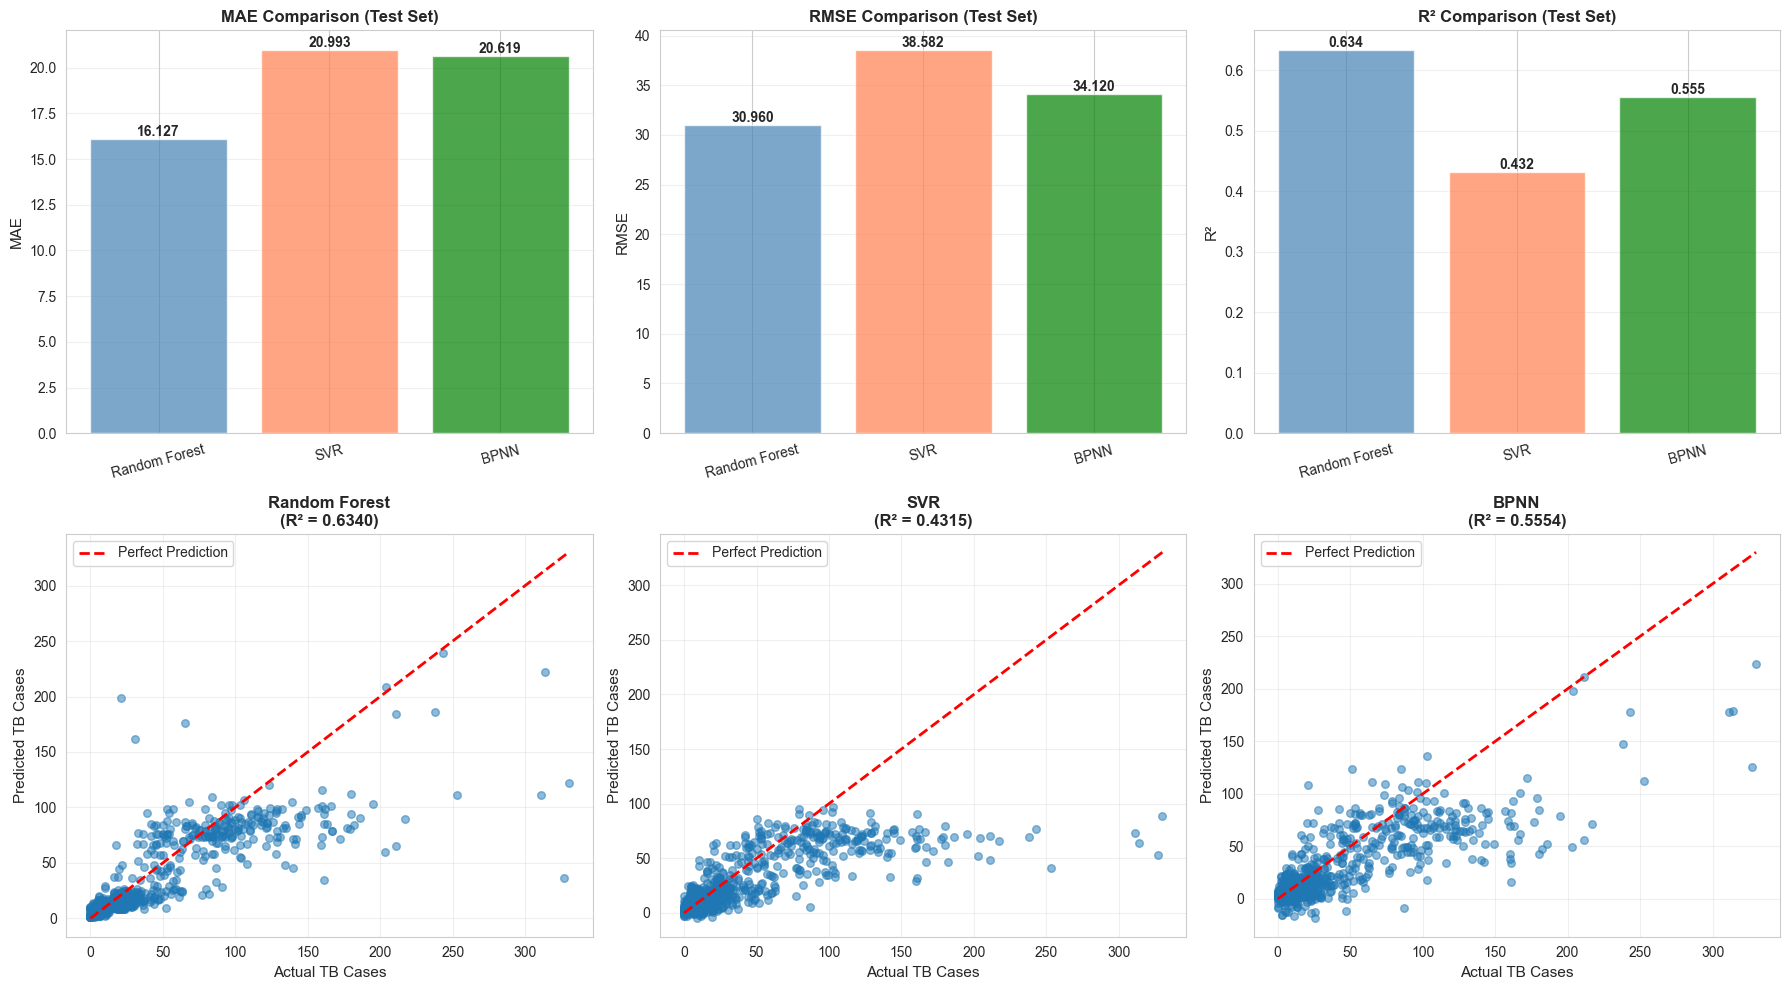


MODEL DEVELOPMENT COMPLETE!

Best performing model: Random Forest
Test R² Score: 0.6340

Next steps:
  1. Hyperparameter tuning for best model
  2. Feature importance analysis
  3. Error analysis and residual plots


In [17]:
# CELL 10: Visualize Model Performance
# ------------------------------------------------------------
print("\n" + "="*70)
print("VISUALIZING MODEL PERFORMANCE")
print("="*70)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Metrics comparison
metrics = ['MAE', 'RMSE', 'R²']
test_metrics = [
    [mae_test_rf, mae_test_svr, mae_test_bpnn],
    [rmse_test_rf, rmse_test_svr, rmse_test_bpnn],
    [r2_test_rf, r2_test_svr, r2_test_bpnn]
]

for idx, (metric, values) in enumerate(zip(metrics, test_metrics)):
    axes[0, idx].bar(models, values, color=['steelblue', 'coral', 'green'], alpha=0.7)
    axes[0, idx].set_ylabel(metric, fontsize=11)
    axes[0, idx].set_title(f'{metric} Comparison (Test Set)', fontsize=12, fontweight='bold')
    axes[0, idx].tick_params(axis='x', rotation=15)
    axes[0, idx].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(values):
        axes[0, idx].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Prediction vs Actual plots
predictions = [
    ('Random Forest', y_pred_rf_test),
    ('SVR', y_pred_svr_test),
    ('BPNN', y_pred_bpnn_test)
]

for idx, (name, preds) in enumerate(predictions):
    axes[1, idx].scatter(y_test, preds, alpha=0.5, s=30)
    axes[1, idx].plot([y_test.min(), y_test.max()], 
                      [y_test.min(), y_test.max()], 
                      'r--', lw=2, label='Perfect Prediction')
    axes[1, idx].set_xlabel('Actual TB Cases', fontsize=11)
    axes[1, idx].set_ylabel('Predicted TB Cases', fontsize=11)
    axes[1, idx].set_title(f'{name}\n(R² = {test_metrics[2][idx]:.4f})', 
                          fontsize=12, fontweight='bold')
    axes[1, idx].legend()
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/monthly/model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved to 'figures/monthly/model_comparison.png'")
plt.show()

print("\n" + "="*70)
print("MODEL DEVELOPMENT COMPLETE!")
print("="*70)
print(f"\nBest performing model: {best_model}")
print(f"Test R² Score: {best_r2:.4f}")
print(f"\nNext steps:")
print(f"  1. Hyperparameter tuning for best model")
print(f"  2. Feature importance analysis")
print(f"  3. Error analysis and residual plots")